In [59]:
import re
import random
import pandas as pd
import hashlib

In [60]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].mean() > 80: age_factor = .5
else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1/age_factor) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.05

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [61]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Email Auth and Security,453.395181,56.674398,99.350498,8
VMWare,1010.774021,23.506373,50.599240,43
Logging in Python,1149.759017,82.125644,228.491956,14
Azure Private DNS,1163.315161,61.227114,137.400518,19
Azure AD Authentication,1235.948923,95.072994,259.209342,13
C# Basics,1251.205386,40.361464,83.885657,31
Azure Functions + Visual Studio,1304.355415,100.335032,205.704588,13
RAG Project,1483.682875,92.730180,219.174386,16
Azure Compute Gallery,1608.289918,40.207248,104.897617,40
Debugging in VS Code,1722.749049,101.338179,371.220165,17


# Histogram

sum of ages: ~53482.99


<Axes: >

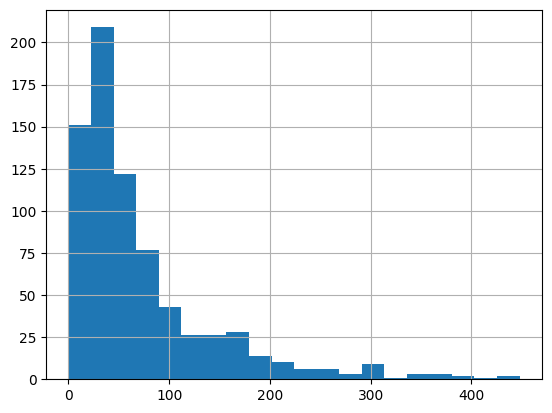

In [62]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [63]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [64]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [65]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

## Headers with greatest age sum first

In [66]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)
# existing_cards.head(10)

## Header with oldest cards first

In [67]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Focus on one header

In [68]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Headers with greatest mean card age first

In [69]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [70]:
# n=10
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // m

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [71]:
n=3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)

Cards found: 742
Total card age: 53482.99


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
0,Python,Q:\nWhat happens if you try to call gen.next()...,a56125c87641d3bb052be7366138b43a,-377.896275,-105.57423,377.896275,3906.246513,0.393089,0,0
1,Python,Q:\nWhat does the pathlib.Path class represent...,21dbd82c30c68008f403052b5b8bcc0d,-220.198494,-105.57423,377.896275,3906.246513,0.393089,3,0
2,Python,Q:\nWhat is the main advantage of using genera...,2d901919fcb841cb40aa64336f70ec47,-175.870127,-105.57423,377.896275,3906.246513,0.393089,6,0
3,Python,Q:\nName a built-in context manager in Python ...,0497d5e31cd7b52a689451e3d4fed69c,-142.220171,-105.57423,377.896275,3906.246513,0.393089,9,0
505,Python,Q:\nHow can you create an infinite iterator cy...,ac5207891d92d3a2a095ef0094710d7f,-125.327198,-105.57423,377.896275,3906.246513,0.393089,12,0
5,Python,Q:\nWhat does an exit code of 0 typically sign...,6583ac672af8fe270936090feed600d6,-91.245334,-105.57423,377.896275,3906.246513,0.393089,15,0
6,Python,Q:\nWhat is the primary purpose of exit codes ...,d5ae26a1eb6bf1e733080a8396f21e2d,-74.630057,-105.57423,377.896275,3906.246513,0.393089,18,0
7,Python,Q:\nHow do you make a custom object iterable?\...,642fdcdd1aca5eb88edcda4b9d62fa3d,-63.380656,-105.57423,377.896275,3906.246513,0.393089,21,0
265,Python,Q:\nWhich Python module provides an object-ori...,e0f21808be1ac9152eaecf47c5a28d93,-50.597054,-105.57423,377.896275,3906.246513,0.393089,24,0
9,Python,Q:\nHow can you create a context manager using...,51557838e96944a86fd1f872036622f7,-43.136618,-105.57423,377.896275,3906.246513,0.393089,27,0


## Age Max

In [72]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [73]:
# n=4
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [74]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [75]:
existing_cards.sort_values('age', ascending=True).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
51,Azure Functions + PP365,HTTP Triggers\nA type of function trigger that...,b9e42ab2e8e591023bd1aa43b8509bfc,-447.863681,-91.772630,447.863681,1927.225224,0.602073,0,0
104,Azure Developer Associate,Where do Application Insights telemetry tables...,d5a8469fce507684c17e1dc224588031,-425.867422,-81.825642,425.867422,7446.133395,0.024971,0,0
356,Azure Developer Associate,Why choose Azure Container Apps instead of Azu...,8c3d7ea082d3ab09d66623077af2f1b9,-404.983812,-81.825642,425.867422,7446.133395,0.024971,1,1
66,PnP PowerShell,Secure Password Handling\nPractices for managi...,274158ed857c87a86d296e65705f10da,-389.295250,-83.259523,389.295250,4995.571371,0.564359,0,0
598,Azure Developer Associate,Where do you associate a stored access policy ...,902bb129e8b619f0bbcf5a9a924c2230,-388.421839,-81.825642,425.867422,7446.133395,0.024971,2,2
0,Python,Q:\nWhat happens if you try to call gen.next()...,a56125c87641d3bb052be7366138b43a,-377.896275,-105.574230,377.896275,3906.246513,0.393089,0,0
13,Debugging in VS Code,"1. Debugger\nA tool used to inspect, control, ...",e5f2354be4982ffd49ff5162d37e9a30,-371.220165,-101.338179,371.220165,1722.749049,0.488939,0,0
304,Azure Functions + PP365,Virtual Environment Activation\nThe process of...,f4ebac7aac964a3452e1734f5f37fcea,-366.111542,-91.772630,447.863681,1927.225224,0.602073,1,1
258,Python,Q:\nWhat are the two essential methods that an...,558bcbe4e40c504fe6e977eb903fb48d,-345.888654,-105.574230,377.896275,3906.246513,0.393089,1,1
319,PnP PowerShell,System.IO.Stream (System.IO)\nRepresents a seq...,3f146f4a53f3f36ced6256f3cfc16375,-344.333122,-83.259523,389.295250,4995.571371,0.564359,1,1


In [76]:
existing_cards.head(10).sum()

head                   PythonPythonPythonPythonPythonPythonPythonPyth...
body                   Q:\nWhat happens if you try to call gen.next()...
hash                   a56125c87641d3bb052be7366138b43a21dbd82c30c680...
age                                                         -1364.501985
subject_mean_age                                            -1055.742301
subject_highest_age                                          3778.962754
subject_age_sum                                             39062.465129
head_random_roll                                                 3.93089
count                                                                135
n_fold                                                                 0
dtype: object

In [77]:
existing_cards['age'].mean()

-72.07950013296892